<a href="https://colab.research.google.com/github/leoclementliao/bert-cls-notebook/blob/master/FinalVersion_S4_Robeta_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Sun Apr 26 21:33:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
version_name = 'FV_Reberta_finuning'
test_name = f'/content/drive/My Drive/Colab Notebooks/kaggle_covid19NLP/submission/test_sub_{version_name}.csv'
lr_global = 1e-6
# lr_dense = 2e-4
batch_size = 64
epochs_num = 3

In [4]:
% cp -r /content/drive/My\ Drive/Colab\ Notebooks/kaggle_covid19NLP /content
% cd /content/kaggle_covid19NLP/notebook
! unzip /content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch.zip -d /content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch


/content/kaggle_covid19NLP/notebook
Archive:  /content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch.zip
  inflating: /content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch/config.json  
  inflating: /content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch/pytorch_model.bin  
  inflating: /content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch/vocab.txt  


# Install transformers library

In [5]:
!pip install transformers

     |████████████████████████████████| 573kB 7.1MB/s 
     |████████████████████████████████| 3.7MB 20.5MB/s 
     |████████████████████████████████| 890kB 57.2MB/s 
     |████████████████████████████████| 1.0MB 55.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=c2288f8a0534c8b09d07ff2a85517210fe6d6efc5431ae2c721a3de642101e31
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
# import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# from tensorflow.keras.layers import (GlobalAveragePooling1D, Reshape, Conv1D,
#                                      multiply)
import os
import time, gc

from transformers import *
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Enable XLA
#tf.config.optimizer.set_jit(True)

# Enable AMP
#tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

2.2.0-rc3


In [8]:
TRAIN_PATH = '../data/train_dataset/nCoV_100k_train.labled.csv' 

TEST_PATH = '../data/test_dataset/nCov_10k_test.csv'
SUB_PATH = '../data/submit_example.csv'


MAX_SEQUENCE_LENGTH = 140
input_categories = '微博中文内容'
output_categories = '情感倾向'

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train = df_train[df_train[output_categories].isin(['-1','0','1'])]

df_sub = pd.read_csv(SUB_PATH)
print('train shape =', df_train.shape)
print('test shape =', df_test.shape)

train shape = (99913, 7)
test shape = (10000, 6)


In [0]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns].astype(int) + 1)
outputs = compute_output_arrays(df_train, output_categories)


# Convert tokens to feature vectors
<img src="https://imgkr.cn-bj.ufileos.com/341d1c83-45cf-4e9b-a656-a547cd0f2c67.png" width="50%" height="50%" />

transformer chinese weight
- https://github.com/ymcui/Chinese-BERT-wwm
- https://github.com/brightmart/roberta_zh



In [0]:
def _convert_to_transformer_inputs(instance, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    """ return input_ids,token_type_ids,attention_mask"""
    inputs = tokenizer.encode_plus(instance,
        add_special_tokens=True,
        max_length=max_sequence_length,
        truncation_strategy= 'longest_first')

    input_ids =  inputs["input_ids"]
    input_masks = inputs["attention_mask"]
    input_segments = inputs["token_type_ids"]
    padding_length = max_sequence_length - len(input_ids)
    #填充
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)
    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for instance in tqdm(df[columns]):
        
        ids, masks, segments = _convert_to_transformer_inputs(str(instance), tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)
           ]

In [11]:
# BERT_PATH = '/content/kaggle_covid19NLP/bert_base_chinese'
# tokenizer = BertTokenizer.from_pretrained(BERT_PATH+'/bert-base-chinese-vocab.txt')

tokenizer = BertTokenizer.from_pretrained('/content/kaggle_covid19NLP/RoBERTa_zh_L12_PyTorch/vocab.txt')

inputs = compute_input_arrays(df_train, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
100%|██████████| 10000/10000 [00:05<00:00, 1823.49it/s]


In [12]:
tokenizer.encode_plus("武汉加油",
        add_special_tokens=True,
        max_length=20,
        truncation_strategy= 'longest_first')


{'attention_mask': [1, 1, 1, 1, 1, 1],
 'input_ids': [101, 3636, 3727, 1217, 3779, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0]}

# BERT model

https://huggingface.co/models


<img src="https://imgkr.cn-bj.ufileos.com/9115ac01-f455-498b-8c38-9c4abb04046c.png" width="50%" height="50%" />




In [0]:
## Not used in this compitition
def Focal_Loss(y_true, y_pred, alpha=0.5, gamma=2):
    """
    focal loss for multi-class classification
    fl(pt) = -alpha*(1-pt)^(gamma)*log(pt)
    :param y_true: ground truth one-hot vector shape of [batch_size, nb_class]
    :param y_pred: prediction after softmax shape of [batch_size, nb_class]
    :param alpha:
    :param gamma:
    :return:
    """
    y_pred += tf.keras.backend.epsilon()
    ce = -y_true * tf.math.log(y_pred)
    weight = tf.pow(1 - y_pred, gamma) * y_true
    fl = ce * weight * alpha
    reduce_fl = tf.keras.backend.max(fl, axis=-1)
    return reduce_fl

In [0]:
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
checkpoints = []
for fold_index in range(5):
    model_name = 'emo_fold_%d_bert_f1_{epoch:02d}.h5' % fold_index#{out_dense_1_accuracy:.4f}
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_f1',
                                  mode='max',
                                 verbose=1,save_weights_only=True,
                                 save_best_only=True)
    checkpoints.append(checkpoint)


In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
class Initi(tf.keras.initializers.Initializer ):

    """Initializer that generates tensors initialized to 1.

    """



    def __call__(self, shape, dtype=None):

        out = np.zeros( shape=shape, dtype=np.float32)
        #out[0] = 1
        #out[-1] = -1
        #out[-2] = 0
        #out[-3] = 0
        #out[-4] = 0
        return out


class Weighted_sum(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Weighted_sum, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='weighted_sum', 
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer=Initi(),
                                      trainable=True)
        super(Weighted_sum, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, K.softmax(self.kernel,-2))#tf.linalg.matmul

    def compute_output_shape(self, input_shape):
        return input_shape#(input_shape[0], self.output_dim)


def SE_layer(stacked_layers):
    num_filters_out = stacked_layers.shape[2]
    se = tf.keras.layers.GlobalAveragePooling1D()(stacked_layers)
    se = tf.keras.layers.Reshape((1, num_filters_out))(se)
    se = tf.keras.layers.Conv1D(num_filters_out//4, 1,
                padding='same',
                activation="relu",
                kernel_initializer='he_normal',
                name='SE_layer1')(se)
    se = tf.keras.layers.Conv1D(num_filters_out, 1,
                padding='same',
                activation='sigmoid',
                kernel_initializer='he_normal',
                name='SE_layer2')(se)

    Layers_SE = tf.keras.layers.multiply([stacked_layers, se])
    return Layers_SE

In [0]:
#from tensorflow.keras.legacy import interfaces
import tensorflow.keras.backend as K
from tensorflow.python.keras.optimizers import Optimizer

class Adam_lr_mult(Optimizer):
    """Adam optimizer.
    Adam optimizer, with learning rate multipliers built on Keras implementation
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        
    AUTHOR: Erik Brorson
    """

    def __init__(self, lr=0.001,name = 'mAdam', beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False,
                 multipliers=None, debug_verbose=False,**kwargs):
        super(Adam_lr_mult, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.multipliers = multipliers
        self.debug_verbose = debug_verbose

    #@interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):

            # Learning rate multipliers
            if self.multipliers:
                multiplier = [mult for mult in self.multipliers if mult in p.name]
            else:
                multiplier = None
            if multiplier:
                new_lr_t = lr_t * self.multipliers[multiplier[0]]
                if self.debug_verbose:
                    print('Setting {} to learning rate {}'.format(multiplier[0], new_lr_t))
                    print(K.get_value(new_lr_t))
            else:
                new_lr_t = lr_t
                if self.debug_verbose:
                    print('No change in learning rate {}'.format(p.name))
                    print(K.get_value(new_lr_t))
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - new_lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - new_lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad,
                  'multipliers':self.multipliers}
        base_config = super(Adam_lr_mult, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [0]:
learning_rate_multipliers = {}
learning_rate_multipliers['weighted_sum'] = 500#lr_dense/lr_global
learning_rate_multipliers['dense0'] = 100#lr_dense/lr_global
learning_rate_multipliers['dense1'] = 100#lr_dense/lr_global
learning_rate_multipliers['dense2'] = 100#lr_dense/lr_global
#learning_rate_multipliers['layer_3'] = 0.1


In [0]:
## Not used in this compitition
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    print(epoch)
    lr = 1e-5
    
    if epoch >0:
        lr = 6e-6
    #lr = 0.5*(1+np.cos((epoch/epochs)*np.pi))*lr
    print('Learning rate: ', lr)
    return lr

In [0]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [0]:
def create_model():
    input_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)    
    input_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)    
    input_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)    
    # config = BertConfig.from_pretrained( '../bert_base_chinese/bert-base-chinese-config.json', output_hidden_states=True)
    # bert_model = TFBertModel.from_pretrained('../bert_base_chinese/bert-base-chinese-tf_model.h5', config=config, name='bert_layer')
    config = BertConfig.from_pretrained( '../RoBERTa_zh_L12_PyTorch/config.json', output_hidden_states=True)
    bert_model = TFBertModel.from_pretrained('../RoBERTa_zh_L12_PyTorch/pytorch_model.bin',from_pt=True, config=config, name='bert_layer')
    
    sequence_output, pooler_output, hidden_states = bert_model(input_id, attention_mask=input_mask, token_type_ids=input_atn)
    print(sequence_output.shape)
    print(len(hidden_states))
    #print(hidden_states[-1].shape)
    #(bs,140,768)(bs,768)
    
    stacked_layers = tf.stack([tf.keras.layers.Dropout(0.1)(layer[:, 0, :]) for layer in hidden_states[1:]],axis = -1)#,noise_shape=(None,None,1)
    
    #print(shape)
    # stacked_layers = SE_layer(stacked_layers)
    cls_output = Weighted_sum(1)(stacked_layers)
    cls_output = K.squeeze(cls_output,axis = -1)
    print(cls_output.shape)
    #cls_output = tf.keras.layers.GlobalAveragePooling1D()(cls_output)
    #x = tf.keras.layers.Dropout(0.2)(x)
    #x = tf.keras.layers.Dense(3, activation='softmax',name = "out")(x)
    # multisample dropout (wut): https://arxiv.org/abs/1905.09788
    dense_out = []
    FC0  = tf.keras.layers.Dense(128, activation='relu',name = "dense0")
    FC1 = tf.keras.layers.Dense(128, activation='relu',name = "dense1")
    FC2  = tf.keras.layers.Dense(3, activation='softmax',name = "dense2")
    for _ in range(8):
        x = tf.keras.layers.Dropout(0.5)(cls_output)
        
        x = FC0(x)
        x = tf.keras.layers.Dropout(0.15)(x)
        
        #x = FC1(x)
        #x = tf.keras.layers.Dropout(0.2)(x)
        x = FC2(x)
        dense_out.append(x)
    
    out = tf.keras.layers.average(dense_out)

    model = tf.keras.models.Model(inputs=[input_id, input_mask, input_atn], outputs=out)
    #layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    bert_model.bert.pooler.dense.trainable  = False
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    opt = Adam_lr_mult(lr = lr_global, multipliers=learning_rate_multipliers)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc', f1])

    # FL=lambda y_true,y_pred: Focal_Loss(y_true, y_pred, alpha=0.25, gamma=2)
    # model.compile(loss=FL, optimizer=opt, metrics=['acc', f1])   
    
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(None, 140, 768)
13
(None, 768)


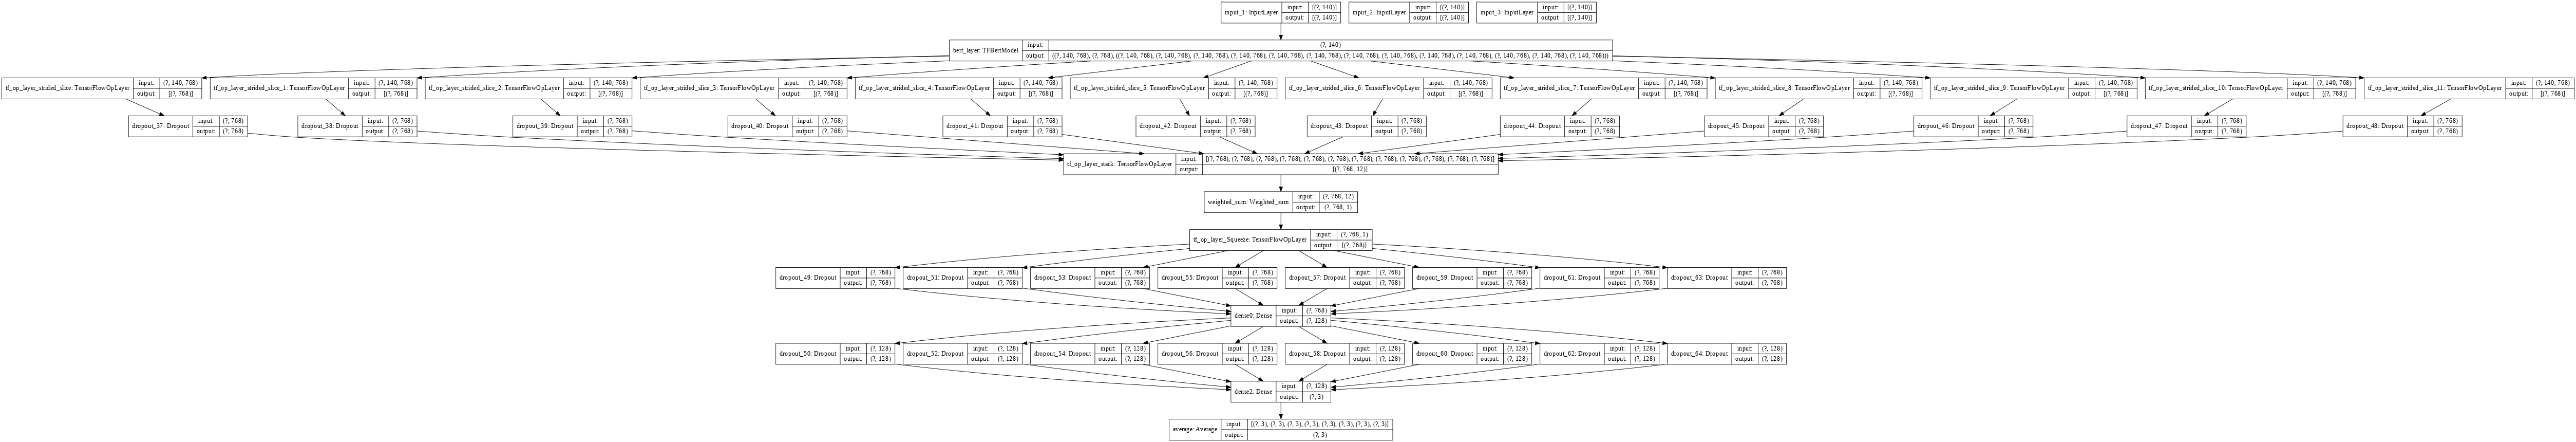

In [22]:
model_pretrained = create_model()
model_pretrained.load_weights("/content/kaggle_covid19NLP/model/Roberta-plabel.h5")
## Visualisation model
tf.keras.utils.plot_model(model_pretrained, show_shapes=True, dpi=64)



In [23]:
model = create_model()
model.get_layer('bert_layer').set_weights(
    model_pretrained.get_layer('bert_layer').get_weights())
model.save_weights("init_weights.h5")
model.summary()

(None, 140, 768)
13
(None, 768)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 140)]        0                                            
__________________________________________________________________________________________________
bert_layer (TFBertModel)        ((None, 140, 768), ( 102267648   input_4[0][0]                    
____________________________________________________________

In [0]:
gkf = StratifiedKFold(n_splits=5).split(X=df_train[input_categories].fillna('-1'), y=df_train[output_categories].fillna('-1'))

In [0]:
## Not used in this competition.

## Tokenizer Back translated data
# df_train['微博中文内容_En'] = ''

# TRAIN_aug_PATH = '../data/train_augmentation/translated_data.csv' 
# df_train_aug = pd.read_csv(TRAIN_aug_PATH)
# df_train['微博中文内容_En'].loc[df_train[input_categories]==df_train[input_categories]] = df_train_aug['微博中文内容_En'].values
# # df_train.iloc[-5:]
# inputs_EnTrans = compute_input_arrays(df_train, '微博中文内容_En', tokenizer, MAX_SEQUENCE_LENGTH)

# def concat_array(A, B, random_order):
#     AB = np.concatenate((A, B), axis=0)
#     AB_random = AB[random_order]
#     return AB_random

In [26]:
# valid_preds = []
# test_preds = []
# for fold, (train_idx, valid_idx) in enumerate(gkf):
#     print("fold:",fold)

#     random_order = np.arange(2*len(train_idx))
#     ## Take partial data to limite training time
#     np.random.shuffle(random_order[len(train_idx):])
#     partial_ratio = 0.50 # 0.5 means only use original data
#     Num_cut = int(len(random_order)*partial_ratio)
#     random_order = random_order[:Num_cut]
#     np.random.shuffle(random_order)

#     train_inputs = [concat_array(inputs[i][train_idx], inputs_EnTrans[i][train_idx], random_order) for i in range(len(inputs))]
#     train_outputs = to_categorical(concat_array(outputs[train_idx], outputs[train_idx], random_order))

#     valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
#     valid_outputs = to_categorical(outputs[valid_idx])

#     model.load_weights("init_weights.h5")
#     model.fit(train_inputs, train_outputs,validation_data= [valid_inputs, valid_outputs],  epochs=epochs_num, batch_size=batch_size,callbacks = [checkpoints[fold]])#
#     model.save_weights(f'bert-{fold}.h5')


valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    print("fold:",fold)
    #if fold!=4:
    #    continue
    train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
    train_outputs = to_categorical(outputs[train_idx])

    valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
    valid_outputs = to_categorical(outputs[valid_idx])

    #K.clear_session()
    model.load_weights("init_weights.h5")
    #model = create_model()
    model.fit(train_inputs, train_outputs,validation_data= [valid_inputs, valid_outputs],  epochs=epochs_num, batch_size=batch_size,callbacks = [checkpoints[fold]])#
    model.save_weights(f'bert-{fold}.h5')

fold: 0
Train on 79930 samples, validate on 19983 samples
Epoch 1/3
79930/79930 [==============================] - ETA: 0s - loss: 0.5847 - acc: 0.7424 - f1: 0.7367
Epoch 00001: val_f1 improved from -inf to 0.76996, saving model to /content/kaggle_covid19NLP/notebook/saved_models/emo_fold_0_bert_f1_01.h5
79930/79930 [==============================] - 1313s 16ms/sample - loss: 0.5847 - acc: 0.7424 - f1: 0.7367 - val_loss: 0.5189 - val_acc: 0.7732 - val_f1: 0.7700
Epoch 2/3
79930/79930 [==============================] - ETA: 0s - loss: 0.5477 - acc: 0.7612 - f1: 0.7584
Epoch 00002: val_f1 did not improve from 0.76996
79930/79930 [==============================] - 1312s 16ms/sample - loss: 0.5477 - acc: 0.7612 - f1: 0.7584 - val_loss: 0.5293 - val_acc: 0.7645 - val_f1: 0.7579
Epoch 3/3
79930/79930 [==============================] - ETA: 0s - loss: 0.5302 - acc: 0.7701 - f1: 0.7673
Epoch 00003: val_f1 did not improve from 0.76996
79930/79930 [==============================] - 1314s 16ms/sa

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [28]:
layer_dict

{'average_1': <tensorflow.python.keras.layers.merge.Average at 0x7f77261a9cf8>,
 'bert_layer': <transformers.modeling_tf_bert.TFBertModel at 0x7f773e2d6208>,
 'dense0': <tensorflow.python.keras.layers.core.Dense at 0x7f7726329940>,
 'dense2': <tensorflow.python.keras.layers.core.Dense at 0x7f77262da2e8>,
 'dropout_102': <tensorflow.python.keras.layers.core.Dropout at 0x7f7726ed7a90>,
 'dropout_103': <tensorflow.python.keras.layers.core.Dropout at 0x7f7726ee53c8>,
 'dropout_104': <tensorflow.python.keras.layers.core.Dropout at 0x7f7726aeb6d8>,
 'dropout_105': <tensorflow.python.keras.layers.core.Dropout at 0x7f77263ba748>,
 'dropout_106': <tensorflow.python.keras.layers.core.Dropout at 0x7f77263d2358>,
 'dropout_107': <tensorflow.python.keras.layers.core.Dropout at 0x7f77263ecfd0>,
 'dropout_108': <tensorflow.python.keras.layers.core.Dropout at 0x7f772637f668>,
 'dropout_109': <tensorflow.python.keras.layers.core.Dropout at 0x7f7726396f60>,
 'dropout_110': <tensorflow.python.keras.layer

In [0]:
def softmax(x):

    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

In [30]:
import os
for dirname, _, filenames in os.walk('saved_models/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

saved_models/emo_fold_2_bert_f1_02.h5
saved_models/emo_fold_2_bert_f1_01.h5
saved_models/emo_fold_3_bert_f1_02.h5
saved_models/emo_fold_4_bert_f1_01.h5
saved_models/emo_fold_3_bert_f1_01.h5
saved_models/emo_fold_0_bert_f1_01.h5
saved_models/emo_fold_1_bert_f1_01.h5


In [0]:
test_preds = []
def cal_5fold_prediction():
    #model = create_model()
    model.load_weights("bert-0.h5")
    test_preds.append(model.predict(test_inputs,batch_size = 32))
    model.load_weights("bert-1.h5")
    test_preds.append(model.predict(test_inputs,batch_size = 32))
    model.load_weights("bert-2.h5")
    test_preds.append(model.predict(test_inputs,batch_size = 32))
    model.load_weights("bert-3.h5")
    test_preds.append(model.predict(test_inputs,batch_size = 32))
    model.load_weights("bert-4.h5")
    test_preds.append(model.predict(test_inputs,batch_size = 32))


In [32]:
cal_5fold_prediction()# 6min
print(len(test_preds))

5


In [33]:
sub = np.average(test_preds, axis=0)
sub = np.argmax(sub,axis=1)
df_sub = df_test[['微博id']]
df_sub['y'] = sub-1
df_sub.columns=['id','y']
# df_sub["y"].value_counts()
df_sub.to_csv(test_name,index=False, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
model.load_weights("/content/kaggle_covid19NLP/model/Roberta-plabel.h5")
sub = model.predict(test_inputs,batch_size = 32)
sub = np.argmax(sub,axis=1)
df_sub = df_test[['微博id']]
df_sub['y'] = sub-1
df_sub.columns=['id','y']
# df_sub["y"].value_counts()
df_sub.to_csv(f'/content/drive/My Drive/Colab Notebooks/kaggle_covid19NLP/submission/test_sub_Roberta_plabel.csv',index=False, encoding='utf-8')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Bert layers name

[<tf.Variable 'tf_bert_model/bert/embeddings/word_embeddings/weight:0' shape=(21128, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._0/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._1/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._2/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._3/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._4/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>,
<tf.Variable 'tf_bert_model/bert/encoder/layer_._5/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._5/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._6/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._7/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._8/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._9/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._10/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/self/query/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/self/query/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/self/key/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/self/value/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/output/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/attention/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/intermediate/dense/kernel:0' shape=(768, 3072) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/intermediate/dense/bias:0' shape=(3072,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/output/dense/kernel:0' shape=(3072, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/output/dense/bias:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/gamma:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/beta:0' shape=(768,) dtype=float32>, <tf.Variable 'tf_bert_model/bert/pooler/dense/kernel:0' shape=(768, 768) dtype=float32>, <tf.Variable 'tf_bert_model/bert/pooler/dense/bias:0' shape=(768,) dtype=float32>,